# ML2 (CSCI 4052U) Exam: RL

Installs:
- pip install gymnasium
- pip install swig
- pip install "gymnasium[box2d]"

In [1]:
import gymnasium as gym
import numpy as np
import time
import math
from matplotlib import pyplot as plt

Lunar Lander Page: https://gymnasium.farama.org/environments/box2d/lunar_lander/

64 possible states, 4 actions (left, down, right, up)

In [44]:



# Runs the requested amount of episodes using Q-Learning
# episodes = # of episodes to run through
# learning_rate = 0 to 1, closer to 1 results in newer episodes taking higher priority in the q-values, changing the values faster
# discount_factor = 0 to 1, closer to 1 values future rewards highly, closer to 0 focuses on immediate rewards more
# epsilon = 0 to 1, chance of taking a random action (1 is always random, 0 is always optimal action as per q values)
# epsilon_change = how much to lower epsilon by per episode (over time max q-value should take priority and exploration minimized)
# slippery = If False, the action requested is always followed through on. If True, the action requested is followed through on 1/3 of the time,
#            and the two perpendicular actions are taken 1/3 of the time each (ex. request=left (1/3 chance), 1/3 chance of slipping up, 1/3 of down)
# render = None for no visualization, "Human" to see visualization

def run_episodes(episodes, learning_rate=0.05, discount_factor=0.95, epsilon=1, epsilon_change=0.01, slippery=True, render=None, debug=False):
    env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=slippery, render_mode=render)

    # 64 states (0 to 63) and 4 actions (0 = left, 1 = down, 2 = right, 3 = up)
    q = np.zeros((env.observation_space.n, env.action_space.n)) # q-value storage
    rng = np.random.default_rng() # random number from 0 to 1 (to determine if random action should be taken)
    completions = np.full(episodes,False)
    ep_lengths = np.zeros(episodes)
    ep_epsilons = np.zeros(episodes)
    checkpoints = math.floor(episodes/10) # Print statement at 10% completion intervals

    print("Ran using the following settings:")
    print("Episodes:", episodes)
    print("Learning Rate:", learning_rate)
    print("Discount Factor:", discount_factor)
    print("Initial Epsilon:", epsilon)
    print("Epsilon Decay (per episode):", epsilon_change)
    print("Slippery:", slippery)
    print("")

    for _ in range(episodes):
        state, info = env.reset()
        

        if debug:
            print("Episode", _, " , Epsilon:", epsilon)
        elif (_+1)%checkpoints==0:
            print("Episode", _, " , Epsilon:", round(epsilon,3), " | Completions so Far:", completions.sum(), " | Success Rate so Far:", round(completions.sum()/_,3)*100,"%")
          

        while True:

            if rng.random() < epsilon:
                action = env.action_space.sample() # Random action
            else:
                action = np.argmax(q[state,:])

            # new_state: After taking the action calculated above, what position are we now in? (0-63)
            # reward: The reward for taking that action (reach goal = +1, reach hole/frozen = 0)
            # terminated: True if the player moves into a hole OR the player reaches the goal
            # truncation: True if the limit (length of episode) is reached, this is 200 for 8x8 env
            # info: number from 0 to 1 with odds of taking the action requested (1/3 if is_slippery, 1 otherwise)
            new_state, reward, terminated, truncated, info = env.step(action)

            if reward == 1:
                completions[_] = True

            q[state,action] = q[state,action] + learning_rate * (reward + discount_factor * max(q[new_state,:]) -q[state,action])

            state = new_state
            ep_lengths[_] += 1

            if terminated or truncated:
                if render == "Human":
                    time.sleep(0.05)
                break

        ep_epsilons[_] = epsilon
        epsilon -= epsilon_change # Lower Epsilon by specified amount
        if epsilon < 0:
            epsilon = 0

    time.sleep(0.5)
    env.close()
    print("\nSimple Breakdown:")
    print("Episodes:", episodes)
    print("Successful Episodes:", completions.sum())
    print("Failed Episodes:", (episodes-completions.sum()))
    print("Success Rate:", round(((completions.sum())/(episodes))*100,3), "%")

    # np.convolve will compute the rolling mean for 100 episodes

    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(completions, np.ones(100), 'valid'))
    axs[0].set_title("Successful Episodes")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("# of Successful Episodes Out of Past 100")

    ax2 = axs[0].twinx()
    ax2.plot(np.convolve(ep_epsilons, np.ones(100), 'valid') / 100, color='red')
    ax2.set_ylabel("Epsilon (Rolling 100 Episode Mean)")
    ax2.set_ylim([0, 1])
    

    axs[1].plot(np.convolve(ep_lengths, np.ones(100), 'valid') / 100)
    axs[1].set_title("Episode Lengths")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Length")

    

Ran using the following settings:
Episodes: 110000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 1e-05
Slippery: False

Episode 10999  , Epsilon: 0.89  | Completions so Far: 57  | Success Rate so Far: 0.5 %
Episode 21999  , Epsilon: 0.78  | Completions so Far: 465  | Success Rate so Far: 2.1 %
Episode 32999  , Epsilon: 0.67  | Completions so Far: 1787  | Success Rate so Far: 5.4 %
Episode 43999  , Epsilon: 0.56  | Completions so Far: 4756  | Success Rate so Far: 10.8 %
Episode 54999  , Epsilon: 0.45  | Completions so Far: 9407  | Success Rate so Far: 17.1 %
Episode 65999  , Epsilon: 0.34  | Completions so Far: 15814  | Success Rate so Far: 24.0 %
Episode 76999  , Epsilon: 0.23  | Completions so Far: 23760  | Success Rate so Far: 30.9 %
Episode 87999  , Epsilon: 0.12  | Completions so Far: 33063  | Success Rate so Far: 37.6 %
Episode 98999  , Epsilon: 0.01  | Completions so Far: 43516  | Success Rate so Far: 44.0 %
Episode 109999  , Epsilon: 

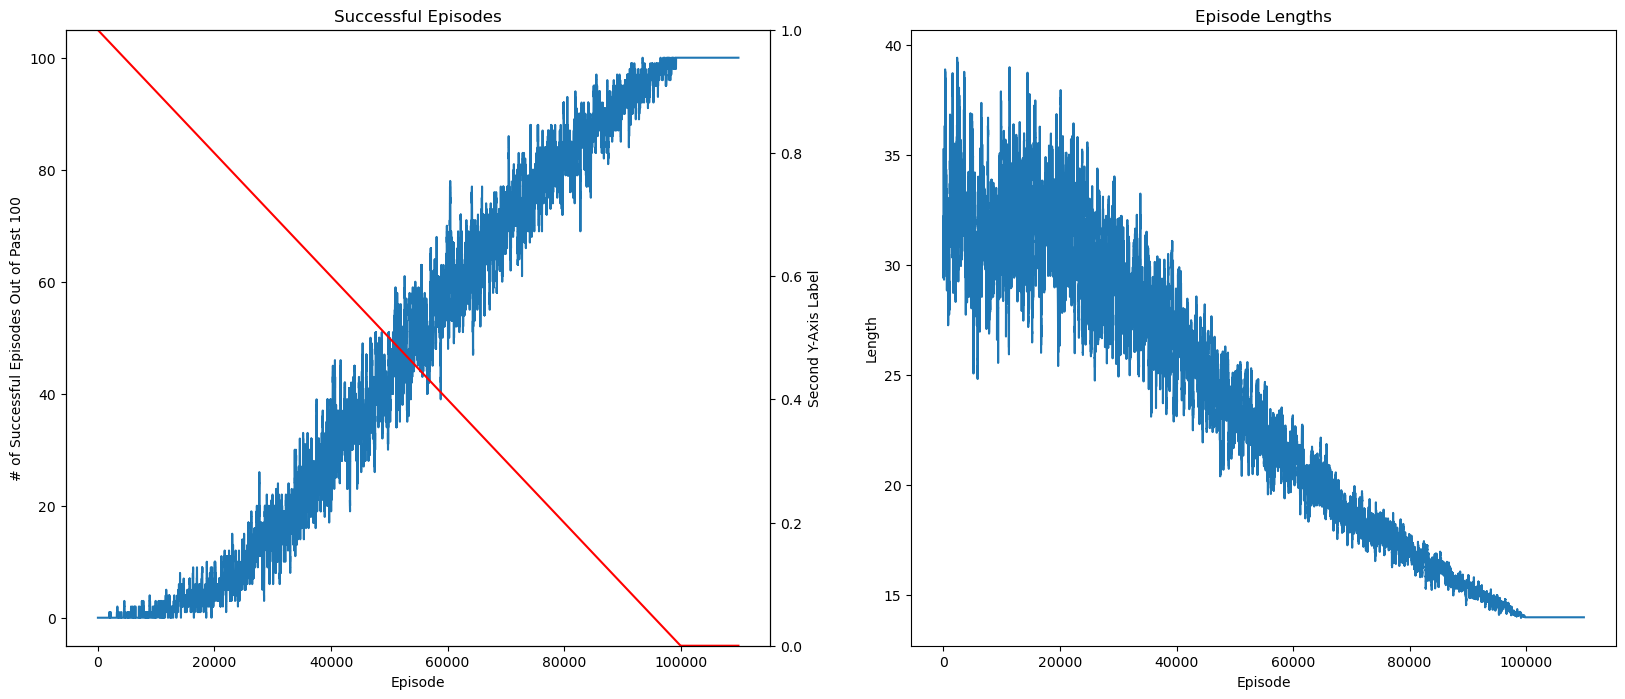

In [43]:
# render="Human" to visualize
# Slippery = False
run_episodes(110000, epsilon_change=0.00001, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 20000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 6e-05
Slippery: False

Episode 1999  , Epsilon: 0.88  | Completions so Far: 13  | Success Rate so Far: 0.7000000000000001 %
Episode 3999  , Epsilon: 0.76  | Completions so Far: 100  | Success Rate so Far: 2.5 %
Episode 5999  , Epsilon: 0.64  | Completions so Far: 426  | Success Rate so Far: 7.1 %
Episode 7999  , Epsilon: 0.52  | Completions so Far: 1034  | Success Rate so Far: 12.9 %
Episode 9999  , Epsilon: 0.4  | Completions so Far: 2065  | Success Rate so Far: 20.7 %
Episode 11999  , Epsilon: 0.28  | Completions so Far: 3394  | Success Rate so Far: 28.299999999999997 %
Episode 13999  , Epsilon: 0.16  | Completions so Far: 4983  | Success Rate so Far: 35.6 %
Episode 15999  , Epsilon: 0.04  | Completions so Far: 6851  | Success Rate so Far: 42.8 %
Episode 17999  , Epsilon: 0  | Completions so Far: 8843  | Success Rate so Far: 49.1 %
Episode 19999

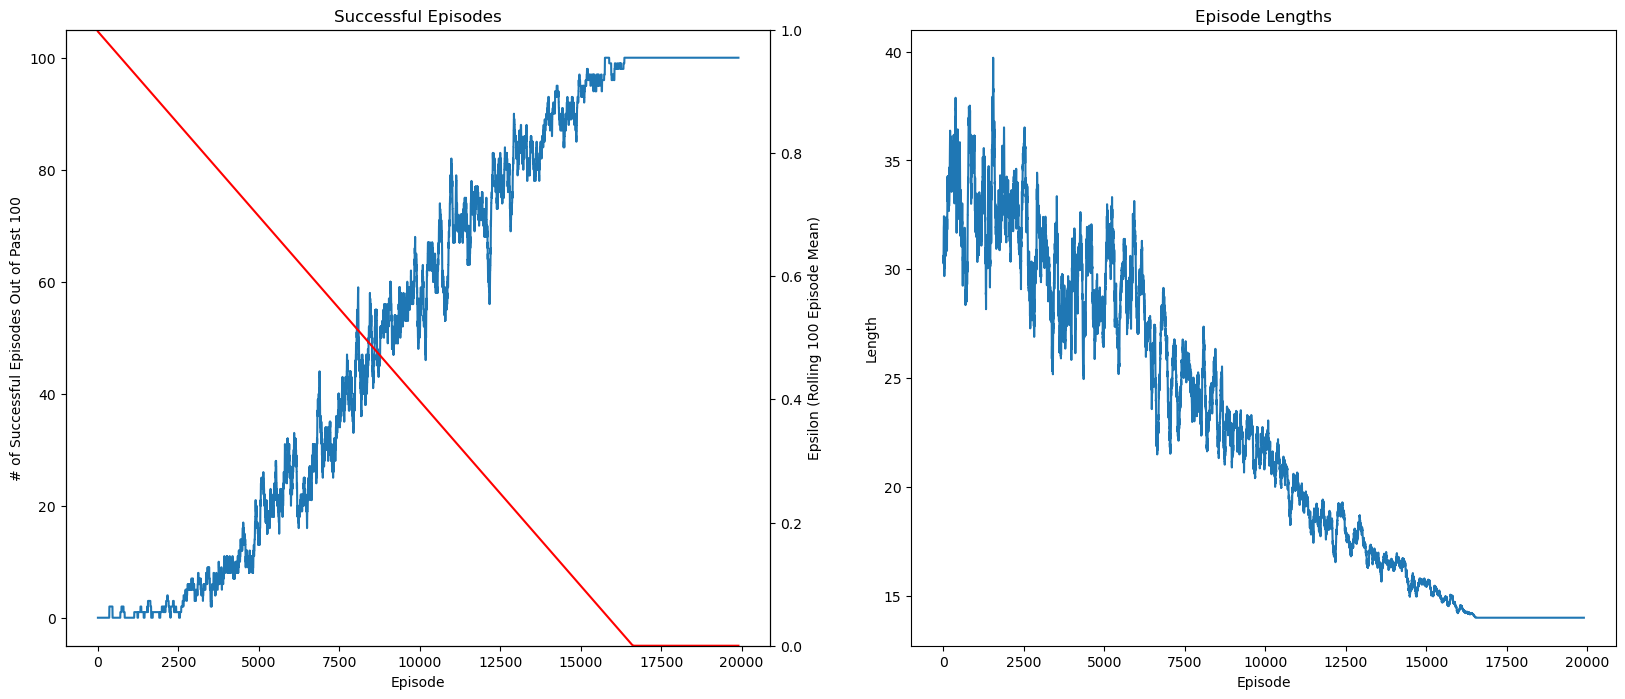

In [47]:
# Slippery = False
# Lower Episode Count
run_episodes(20000, epsilon_change=0.00006, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 1750000
Learning Rate: 0.005
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 6e-07
Slippery: True

Episode 174999  , Epsilon: 0.895  | Completions so Far: 447  | Success Rate so Far: 0.3 %
Episode 349999  , Epsilon: 0.79  | Completions so Far: 1438  | Success Rate so Far: 0.4 %
Episode 524999  , Epsilon: 0.685  | Completions so Far: 3532  | Success Rate so Far: 0.7000000000000001 %
Episode 699999  , Epsilon: 0.58  | Completions so Far: 7504  | Success Rate so Far: 1.0999999999999999 %
Episode 874999  , Epsilon: 0.475  | Completions so Far: 14920  | Success Rate so Far: 1.7000000000000002 %
Episode 1049999  , Epsilon: 0.37  | Completions so Far: 28158  | Success Rate so Far: 2.7 %
Episode 1224999  , Epsilon: 0.265  | Completions so Far: 51390  | Success Rate so Far: 4.2 %
Episode 1399999  , Epsilon: 0.16  | Completions so Far: 90488  | Success Rate so Far: 6.5 %
Episode 1574999  , Epsilon: 0.055  | Completions so Far: 154

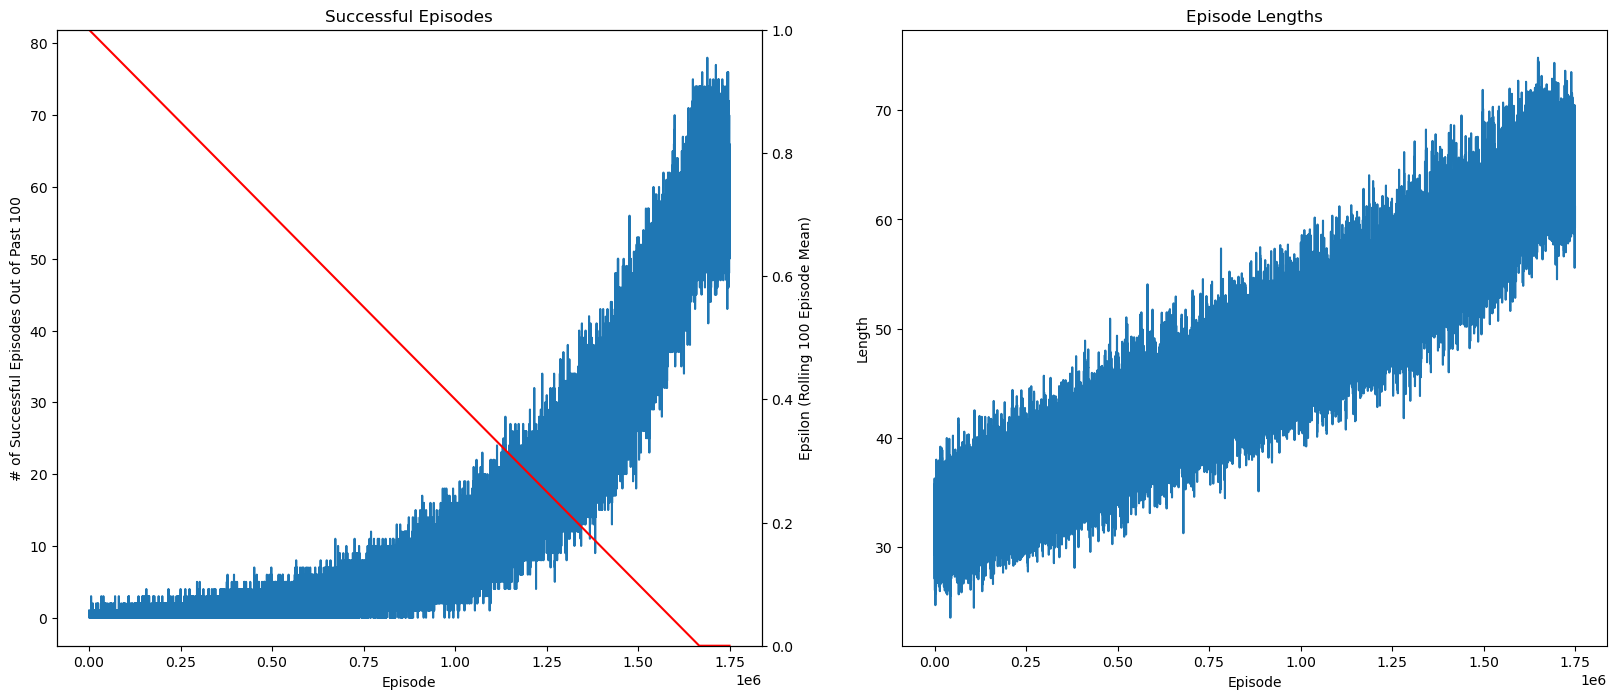

In [54]:
# Slippery = True
run_episodes(1750000, epsilon_change=0.0000006, slippery=True, learning_rate=0.005)

Research Resources:
- AI (CSCI 4610U) Lectures
- ML2 (CSCI 4052U) Lectures
- https://www.youtube.com/watch?v=ZhoIgo3qqLU - FrozenLake Gymnasium
- https://gymnasium.farama.org/environments/toy_text/frozen_lake/
